# Preprocessing Data for `protein_embeddings_w_residual.parquet`

In [5]:
import pandas as pd

In [21]:
df = pd.read_csv('../train.csv')

# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in df['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
df['Sequence'] = sequences
df.head()

,mutant,DMS_score,Sequence
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


In [34]:
import torch
import esm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ESM model and move it to GPU
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Example: ESM-2 model
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()  # Set to eval mode

# Extract ESM embeddings using GPU
def extract_esm_embedding(row):
    sequence = row["Sequence"]
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, sequence)])
    batch_tokens = batch_tokens.to(device)  # Move input to GPU

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    
    token_representations = results["representations"][33]  # Use final layer

    sequence_embedding = token_representations.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU for NumPy

    # residual embeddings
    ## before
    mutant_pos = int(row["mutant"][1])
    before_embedding = original_sequence_token_representations[0, mutant_pos].squeeze().cpu().numpy()
    after_embedding = token_representations[0, mutant_pos].squeeze().cpu().numpy()

    return sequence_embedding, before_embedding, after_embedding

Using device: cuda


In [35]:
df[["sequence_embedding", "before_residual_embedding", "after_residual_embedding"]] = df.apply(lambda row: extract_esm_embedding(row), axis=1, result_type="expand")
df.head()

,mutant,DMS_score,Sequence,sequence_embedding,before_residual_embedding,after_residual_embedding
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027215092, -0.078958936, 0.024665572, 0.087...","[0.04977224, -0.032656617, 0.10141596, 0.06524...","[0.046728767, -0.02765824, 0.08907116, 0.06583..."
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02744675, -0.08002918, 0.02497382, 0.087685...","[0.04977224, -0.032656617, 0.10141596, 0.06524...","[0.0480552, -0.030318772, 0.093972184, 0.06486..."
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027746094, -0.08058317, 0.024816157, 0.0884...","[0.04977224, -0.032656617, 0.10141596, 0.06524...","[0.040912185, -0.014682843, 0.08075453, 0.0696..."
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027021263, -0.07973987, 0.024042578, 0.0892...","[0.04977224, -0.032656617, 0.10141596, 0.06524...","[0.040725417, -0.019828573, 0.08023371, 0.0712..."
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.027436636, -0.0795229, 0.02438331, 0.090356...","[0.04977224, -0.032656617, 0.10141596, 0.06524...","[0.0411717, -0.008302458, 0.076355904, 0.07708..."


In [36]:
# Apply embedding extraction

df.to_parquet("protein_embeddings_w_residuals.parquet", engine="pyarrow")

## Query 1

In [63]:
df_query1 = pd.read_csv('../query1.csv')

# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in df_query1['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
df_query1['Sequence'] = sequences
df_query1.head()

,mutant,DMS_score,sequence,Sequence
0,E3L,0.907694,MVNLARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNLARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1,E3W,0.785553,MVNWARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNWARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
2,E3V,0.735405,MVNVARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNVARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
3,E3R,0.862394,MVNRARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNRARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
4,G6A,0.970692,MVNEARANSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNEARANSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


In [64]:
df_query1[["sequence_embedding", "before_residual_embedding", "after_residual_embedding"]] = df_query1.apply(lambda row: extract_esm_embedding(row), axis=1, result_type="expand")
df_query1.head()

,mutant,DMS_score,sequence,Sequence,sequence_embedding,before_residual_embedding,after_residual_embedding
0,E3L,0.907694,MVNLARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNLARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02630587, -0.07783403, 0.025091317, 0.08715...","[0.22061548, 0.030639352, 0.23427473, 0.091955...","[0.1364245, 0.12407979, 0.20172088, 0.06797653..."
1,E3W,0.785553,MVNWARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNWARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026764292, -0.078947954, 0.025023673, 0.088...","[0.22061548, 0.030639352, 0.23427473, 0.091955...","[0.1626399, 0.10677872, 0.2766948, 0.11653806,..."
2,E3V,0.735405,MVNVARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNVARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026362052, -0.07791606, 0.024700128, 0.0860...","[0.22061548, 0.030639352, 0.23427473, 0.091955...","[0.16330962, 0.11128231, 0.21890819, 0.0680341..."
3,E3R,0.862394,MVNRARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNRARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.02539448, -0.07708823, 0.025331028, 0.08656...","[0.22061548, 0.030639352, 0.23427473, 0.091955...","[0.13985127, 0.057395108, 0.27251497, 0.101335..."
4,G6A,0.970692,MVNEARANSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,MVNEARANSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...,"[0.026636722, -0.077505864, 0.024697602, 0.084...","[0.16200434, -0.03876533, 0.12904096, 0.048802...","[0.13964465, -0.015410371, 0.17536883, 0.04159..."


In [65]:
df_query1.to_parquet("protein_embeddings_w_residuals_QUERY1.parquet", engine="pyarrow")

# Training Models
We initially train a MLP, LightGBM, and XGBoost.

In [97]:
df = pd.read_parquet('protein_embeddings_w_residuals.parquet')
df.shape

(1140, 6)

In [98]:
# OPTIONAL - load query 1 data too
df_query1 = pd.read_parquet("protein_embeddings_w_residuals_QUERY1.parquet")
df = pd.concat([df, df_query1], axis=0, ignore_index=True)
df.shape

(1240, 7)

Text(0.5, 1.0, 'Total Dataset Labels')

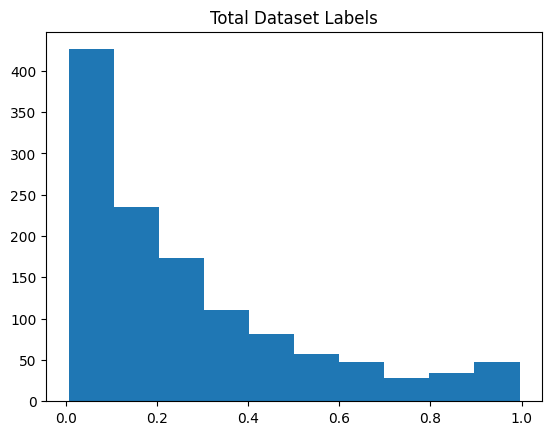

In [99]:
import matplotlib.pyplot as plt
plt.hist(df.DMS_score)
plt.title("Total Dataset Labels")

In [100]:
import numpy as np
X = np.hstack([np.vstack(df["sequence_embedding"].values), np.vstack(df["before_residual_embedding"].values), np.vstack(df["after_residual_embedding"].values)])
X.shape

(1240, 3840)

In [101]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = np.hstack([
    np.vstack(df["sequence_embedding"].values), 
    np.vstack(df["before_residual_embedding"].values), 
    np.vstack(df["after_residual_embedding"].values)
])
y = df["DMS_score"].values

# Convert to PyTorch tensors and move to GPU
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Reshape for MLP

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


## MLP

modified MLP:

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import spearmanr

import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=3048):
        super(MLPRegressor, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.residual_blocks = nn.Sequential(
            ResidualBlock(2048),
            ResidualBlock(2048),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            ResidualBlock(1024),
            ResidualBlock(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            ResidualBlock(512),
            ResidualBlock(512),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            ResidualBlock(256),
            ResidualBlock(256),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            ResidualBlock(128),
            ResidualBlock(128),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.output_layer = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.residual_blocks(x)
        x = self.output_layer(x)
        return x

# Custom Spearman-friendly loss function
def spearman_loss(y_pred, y_true):
    return -torch.cosine_similarity(y_pred.view(1, -1), y_true.view(1, -1))

# Initialize model, loss function, and optimizer
model = MLPRegressor(input_dim=X.shape[1]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)  # Weight decay added
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
epochs = 100_000
best_val_loss = float('inf')
patience, patience_counter = 20_000, 0  # Early stopping

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(X_train)
    loss = spearman_loss(predictions, y_train)  # Rank-based loss
    loss.backward()
    optimizer.step()
    
    # Learning rate scheduling
    scheduler.step(loss)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Early stopping
    if loss.item() < best_val_loss:
        best_val_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = spearman_loss(test_predictions, y_test)

print(f"Test Spearman Loss: {test_loss.item():.4f}")

# Compute Spearman correlation
spearman_corr, _ = spearmanr(y_test.cpu().numpy().flatten(), test_predictions.cpu().numpy().flatten())
print(f"MLP Spearman Correlation: {spearman_corr:.4f}")


Epoch 1000/100000, Loss: -0.7451
Epoch 2000/100000, Loss: -0.7478
Epoch 3000/100000, Loss: -0.7517
Epoch 4000/100000, Loss: -0.7549
Epoch 5000/100000, Loss: -0.7435
Epoch 6000/100000, Loss: -0.7531
Epoch 7000/100000, Loss: -0.7398
Epoch 8000/100000, Loss: -0.7532
Epoch 9000/100000, Loss: -0.7489
Epoch 10000/100000, Loss: -0.7511
Epoch 11000/100000, Loss: -0.7452
Epoch 12000/100000, Loss: -0.7532
Epoch 13000/100000, Loss: -0.7476
Epoch 14000/100000, Loss: -0.7471
Epoch 15000/100000, Loss: -0.7437
Epoch 16000/100000, Loss: -0.7523
Epoch 17000/100000, Loss: -0.7602
Epoch 18000/100000, Loss: -0.7391
Epoch 19000/100000, Loss: -0.7597
Epoch 20000/100000, Loss: -0.7530
Epoch 21000/100000, Loss: -0.7617
Epoch 22000/100000, Loss: -0.7557
Epoch 23000/100000, Loss: -0.7553
Epoch 24000/100000, Loss: -0.7561
Epoch 25000/100000, Loss: -0.7472
Epoch 26000/100000, Loss: -0.7478
Epoch 27000/100000, Loss: -0.7537
Epoch 28000/100000, Loss: -0.7457
Epoch 29000/100000, Loss: -0.7552
Epoch 30000/100000, Los

# Predictions

## Embed Test Set

**WARNING** Check if you actually have to do this. You might already have this

In [52]:
unlabeled_csv = pd.read_csv("../test.csv")

# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in unlabeled_csv['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
unlabeled_csv['Sequence'] = sequences
unlabeled_csv.head()

,mutant,Sequence
0,V1D,MDNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1,V1Y,MYNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
2,V1C,MCNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
3,V1A,MANEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
4,V1E,MENEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


In [53]:
import torch
import esm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ESM model and move it to GPU
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()  # Example: ESM-2 model
batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)
esm_model.eval()  # Set to eval mode

# Extract ESM embeddings using GPU
def extract_esm_embedding(row):
    sequence = row["Sequence"]
    batch_labels, batch_strs, batch_tokens = batch_converter([(None, sequence)])
    batch_tokens = batch_tokens.to(device)  # Move input to GPU

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[33], return_contacts=False)
    
    token_representations = results["representations"][33]  # Use final layer

    sequence_embedding = token_representations.mean(dim=1).squeeze().cpu().numpy()  # Move back to CPU for NumPy

    # residual embeddings
    ## before
    mutant_pos = int(row["mutant"][1])
    before_embedding = original_sequence_token_representations[0, mutant_pos].squeeze().cpu().numpy()
    after_embedding = token_representations[0, mutant_pos].squeeze().cpu().numpy()

    return sequence_embedding, before_embedding, after_embedding

Using device: cuda


In [54]:
unlabeled_csv[["sequence_embedding", "before_residual_embedding", "after_residual_embedding"]] = unlabeled_csv.apply(lambda row: extract_esm_embedding(row), axis=1, result_type="expand")


In [55]:
unlabeled_csv.to_parquet("protein_embeddings_w_residuals_TEST.parquet", engine="pyarrow")

## Inference


In [105]:
df_unlabeled = pd.read_parquet('protein_embeddings_w_residuals_TEST.parquet')
X_unlabeled = np.hstack([
    np.vstack(df_unlabeled["sequence_embedding"].values), 
    np.vstack(df_unlabeled["before_residual_embedding"].values), 
    np.vstack(df_unlabeled["after_residual_embedding"].values)
])
X_unlabeled = torch.tensor(X_unlabeled, dtype=torch.float32, device=device)

(array([3496., 1786.,    4.,  251.,  106.,   26., 2064.,    0.,    7.,
        3584.]),
 array([0.7363596 , 0.94026202, 1.14416444, 1.34806681, 1.55196929,
        1.75587165, 1.95977402, 2.1636765 , 2.36757898, 2.57148123,
        2.77538371]),
 <BarContainer object of 10 artists>)

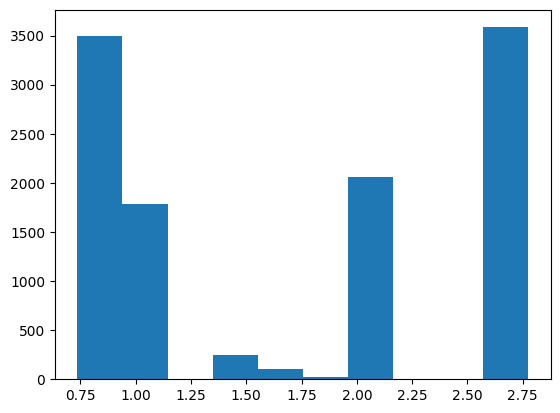

In [106]:
# Rohan's Version
%matplotlib inline
import matplotlib.pyplot as plt
pred = model(X_unlabeled)
pred = pred.detach().cpu().numpy()
plt.hist(pred)

In [107]:
pred = model(X_unlabeled).detach().cpu().numpy()

df_unlabeled["DMS_score_predicted"] = pred
df_unlabeled[["mutant", "DMS_score_predicted"]].to_csv("predictions.csv", index=False)

In [108]:
top10mutants = df_unlabeled.iloc[pred.flatten().argsort()[-10:], :]
mutants = []
for mut in top10mutants["mutant"].values:
    mutants.append(mut)

with open("top10.txt", "w") as f:

    f.write("\n".join(mutants))
